Train Epoch: 1 [0/60000 (0%)]	Loss: 549.721191
Train Epoch: 1 [12800/60000 (21%)]	Loss: 179.175110
Train Epoch: 1 [25600/60000 (43%)]	Loss: 148.724686
Train Epoch: 1 [38400/60000 (64%)]	Loss: 140.504745
Train Epoch: 1 [51200/60000 (85%)]	Loss: 131.009857
====> Epoch: 1 Average loss: 161.8601
Train Epoch: 2 [0/60000 (0%)]	Loss: 128.667831
Train Epoch: 2 [12800/60000 (21%)]	Loss: 120.071846
Train Epoch: 2 [25600/60000 (43%)]	Loss: 122.212494
Train Epoch: 2 [38400/60000 (64%)]	Loss: 120.468529
Train Epoch: 2 [51200/60000 (85%)]	Loss: 116.252449
====> Epoch: 2 Average loss: 120.4792
Train Epoch: 3 [0/60000 (0%)]	Loss: 115.116943
Train Epoch: 3 [12800/60000 (21%)]	Loss: 115.952744
Train Epoch: 3 [25600/60000 (43%)]	Loss: 108.667099
Train Epoch: 3 [38400/60000 (64%)]	Loss: 113.016907
Train Epoch: 3 [51200/60000 (85%)]	Loss: 116.592094
====> Epoch: 3 Average loss: 113.9912
Train Epoch: 4 [0/60000 (0%)]	Loss: 112.842484
Train Epoch: 4 [12800/60000 (21%)]	Loss: 108.019684
Train Epoch: 4 [25600/

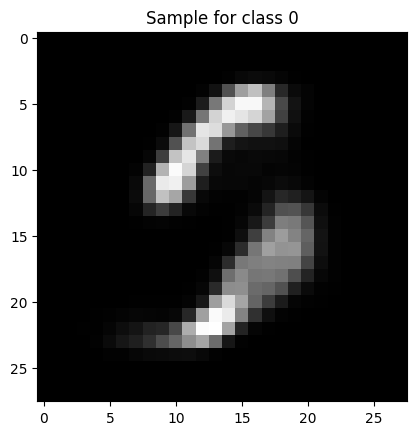

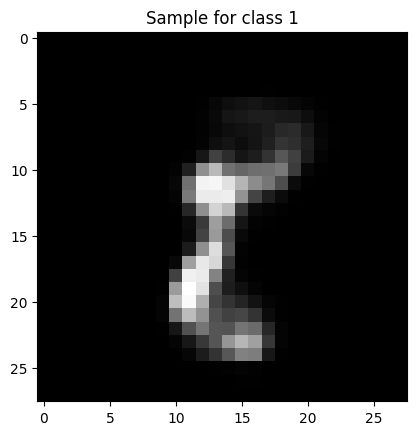

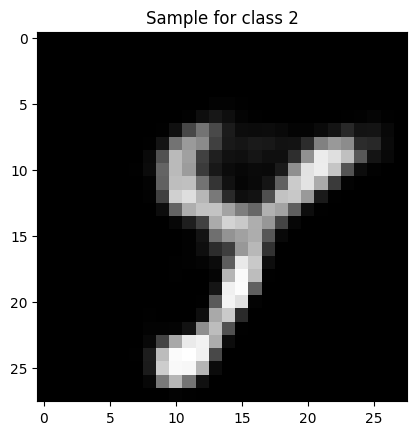

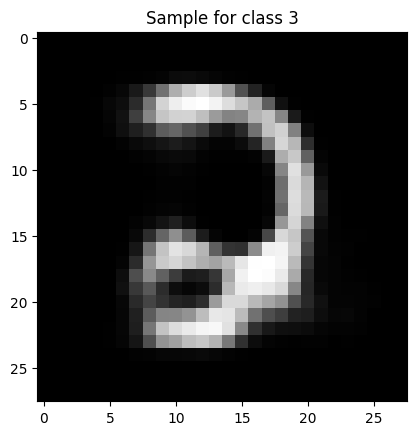

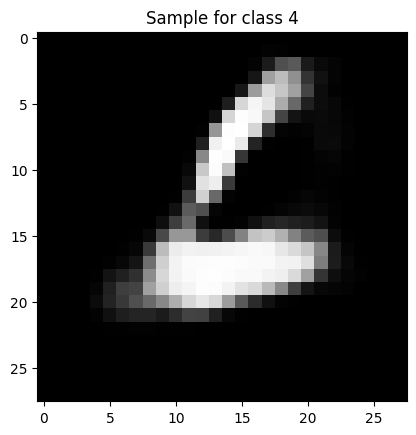

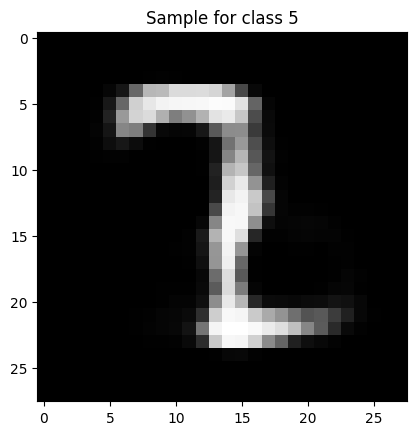

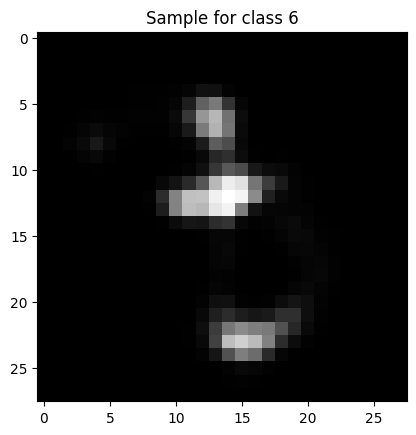

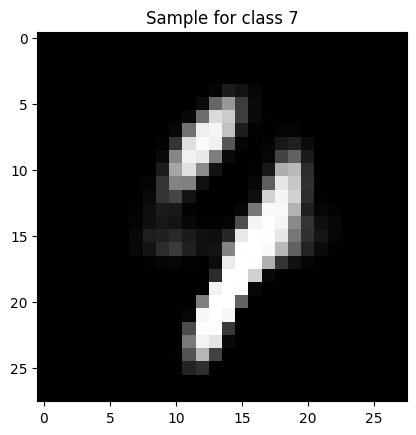

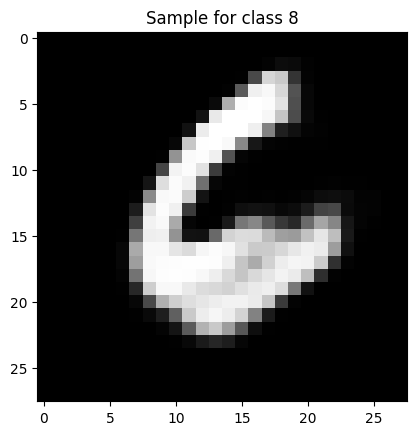

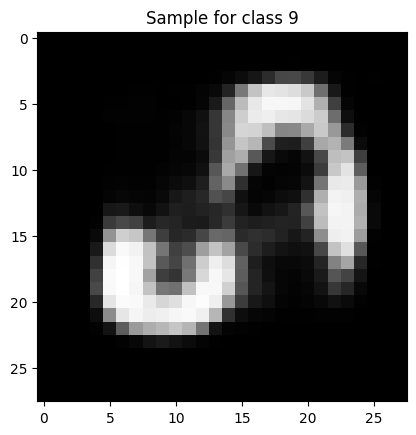

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Define the VAE base class
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, z_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, z_dim * 2)  # to get both mean and log_var
        )
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )
        self.z_dim = z_dim

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        pass

class ConditionalVAE(VAE):
    def __init__(self, input_dim, hidden_dim, z_dim, num_classes):
        super(ConditionalVAE, self).__init__(input_dim, hidden_dim, z_dim)
        self.label_projector = nn.Sequential(
            nn.Linear(num_classes, z_dim),  # Project labels to z_dim instead of hidden_dim
            nn.ReLU(),
        )

    def condition_on_label(self, z, y):
        projected_label = self.label_projector(y.float())
        return z + projected_label

    def forward(self, x, y):
        # Pass the input through the encoder
        encoded = self.encoder(x)
        # Compute the mean and log variance vectors
        mu, log_var = torch.chunk(encoded, 2, dim=1)
        # Reparameterize the latent variable
        z = self.reparameterize(mu, log_var)
        # Pass the latent variable through the decoder
        decoded = self.decoder(self.condition_on_label(z, y))
        # Return the encoded output, decoded output, mean, and log variance
        return encoded, decoded, mu, log_var

    def sample(self, num_samples, y):
        with torch.no_grad():
            # Generate random noise
            z = torch.randn(num_samples, self.z_dim).to(y.device)
            # Pass the noise through the decoder to generate samples
            samples = self.decoder(self.condition_on_label(z, y))
        # Return the generated samples
        return samples

# Load and preprocess the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalizing to [-1, 1]
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# Training settings
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = 28 * 28
hidden_dim = 400
z_dim = 20
num_classes = 10

# Instantiate the model, optimizer, and loss function
model = ConditionalVAE(input_dim, hidden_dim, z_dim, num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCELoss(reduction='sum')

# Training loop
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = (data.view(-1, 28*28) + 1) / 2  # Transform data from [-1, 1] to [0, 1]
        data = data.to(device)
        labels = F.one_hot(labels, num_classes).to(device)
        optimizer.zero_grad()
        encoded, decoded, mu, log_var = model(data, labels)
        recon_loss = criterion(decoded, data)
        kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        loss = recon_loss + kl_div
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}'
                  f' ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')
    print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')

# Train the model
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    train(epoch)

# Generate samples
model.eval()
with torch.no_grad():
    # Generate samples for each class
    for i in range(num_classes):
        label = torch.zeros(1, num_classes).to(device)
        label[0, i] = 1
        sample = model.sample(1, label)
        sample = sample.view(28, 28).cpu().numpy()
        plt.imshow(sample, cmap='gray')
        plt.title(f'Sample for class {i}')
        plt.show()
